In [14]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../src/')
sys.path.append('../problems/')
import models
import generation_utils
import metrics_utils
import tokenizer
import data_utils
from utils import get_best_checkpoint
from factorization import Factorization

In [15]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [16]:
pd.set_option('display.max_colwidth', 999)
pd.set_option('display.max_rows', 9999)

In [17]:
device = torch.device('cuda')

In [18]:
base_path = '../models/factorization/base_30/'

In [19]:
checkpoint = get_best_checkpoint(base_path)

Loading model at ../models/factorization/base_30/checkpoints/40000_0.0493.pt


In [20]:
args = checkpoint['args']

In [21]:
problem = Factorization(args)

In [22]:
t = problem.get_tokenizer()

In [25]:
args.keys()

dict_keys(['data', 'problem_type', 'model_args', 'optimizer', 'scheduler', 'loader', 'io', 'metrics', 'verbose', 'wandb', 'resume_training', 'tokenizer'])

In [27]:
models.Seq2SeqModel()

models.Seq2SeqModel

In [29]:
model = models.Seq2SeqModel(n_tokens = args['tokenizer']['n_tokens'], 
                          pad_token_id = args['tokenizer']['pad_token_id'],
                          **args['model_args'])
model.load_state_dict(checkpoint['model_state_dict'])
model.to(device)
model.eval()

Seq2SeqModel(
  (src_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 128)
  )
  (tgt_embedding): TransformerEmbedding(
    (embedding): Embedding(34, 128)
  )
  (positional_encoding): PositionalEncoding(
    (dropout): Dropout(p=0.05, inplace=False)
  )
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiHeadRelativeAttention(
            (w_q): Linear(in_features=128, out_features=128, bias=False)
            (w_k): Linear(in_features=128, out_features=128, bias=False)
            (w_v): Linear(in_features=128, out_features=128, bias=False)
            (out_proj): Linear(in_features=128, out_features=128, bias=False)
            (pe_mod): PositionalEncoding(
              (dropout): Dropout(p=0.05, inplace=False)
            )
            (w_k_pos): Linear(in_features=128, out_features=128, bias=False)
          )
          (linear1): Linear(in_features=128, out_

# Visualize Embeddings

In [31]:
embeddings = model.src_embedding.embedding.weight.data.cpu().numpy()

In [32]:
tokens = [''.join(t.decode([i], decode_special=True)) for i in range(len(t))]
special_tokens = set(['x', '_', '>', '.'])
tokens = np.array([tok if tok in special_tokens else data_utils.base2dec([int(tok)], args['data']['base']) for tok in tokens])

In [33]:
embeddings.shape

(34, 128)

In [34]:
tokens.shape

(34,)

In [35]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', 'x', '_', '.', '>'],
      dtype='<U11')

## TSNE
* Doesn't seem to be super interesting (over more paramaters than these)

In [36]:
from sklearn.manifold import TSNE

In [39]:
tsne = TSNE()#perplexity=30, learning_rate=200, n_iter=1000)
embeddings_for_plot = tsne.fit_transform(embeddings)

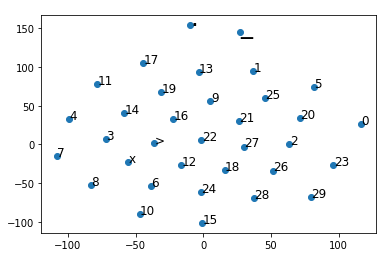

In [40]:
plt.scatter(embeddings_for_plot[:,0], embeddings_for_plot[:,1])
ax = plt.gca()
for tok, (x,y) in zip(tokens, embeddings_for_plot):
    fontsize = 12 if not tok in ['.', '_'] else 24
    ax.annotate(tok, (x+.3,y), fontsize=fontsize)
plt.show()

## Cosine Similarity
* Some embeddings have relatively simlar cosine similarities

In [41]:
from sklearn.metrics.pairwise import cosine_similarity

In [42]:
cs_sim_mat = cosine_similarity(embeddings)
cs_sims = np.triu(cs_sim_mat, 1).ravel()
cs_sims = cs_sims[~np.isclose(cs_sims, 0)]

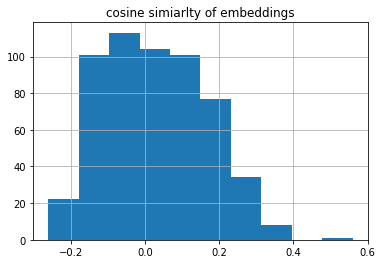

In [43]:
plt.title('cosine simiarlty of embeddings')
pd.Series(cs_sims).hist()
plt.show()

In [44]:
cs_sim_mat.shape

(34, 34)

In [45]:
tokens

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23',
       '24', '25', '26', '27', '28', '29', 'x', '_', '.', '>'],
      dtype='<U11')

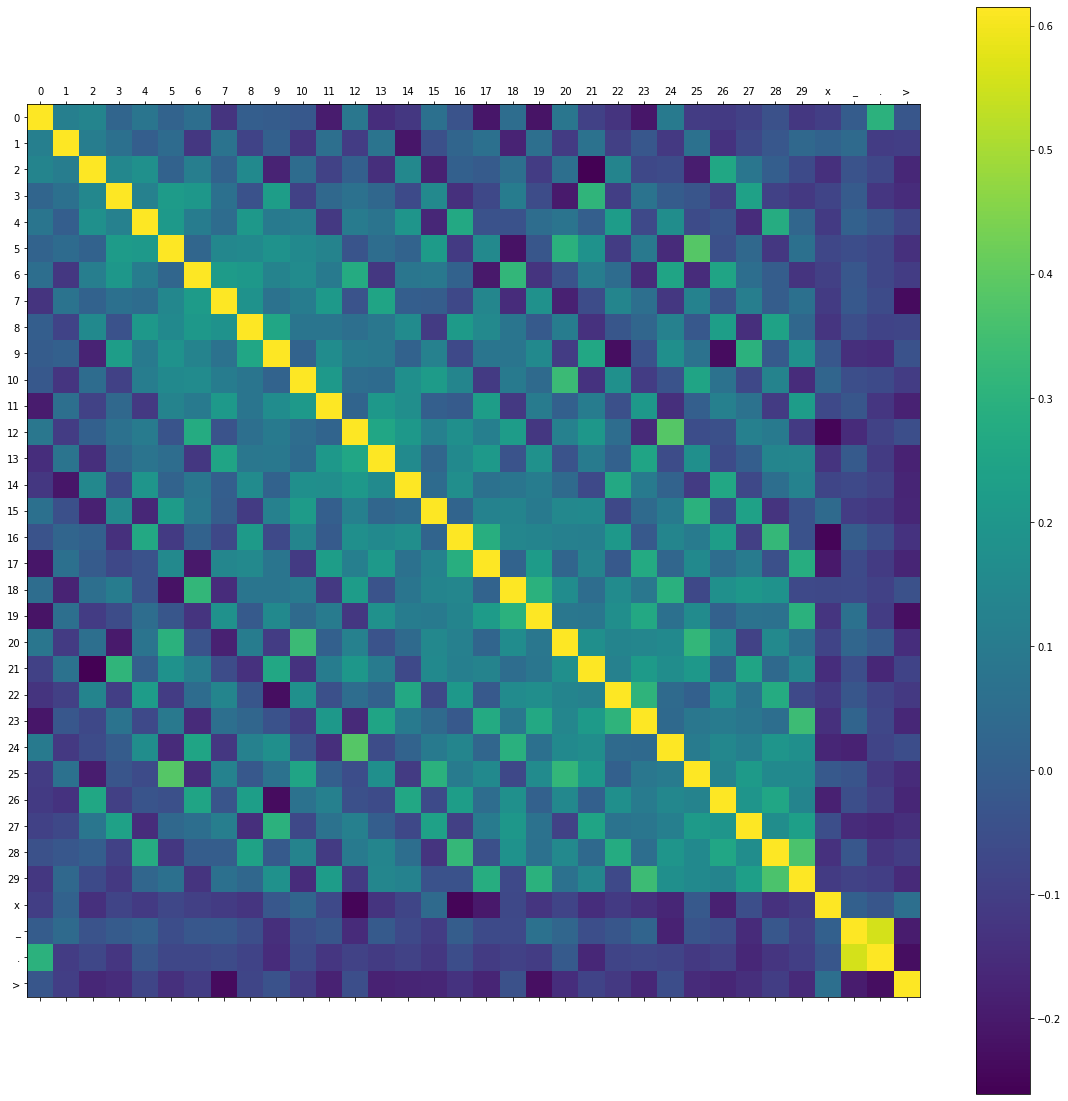

In [46]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
ax = plt.gca()
plt.colorbar(ax.matshow(np.clip(cs_sim_mat, a_min=-1, a_max=cs_sim_mat[cs_sim_mat<.99].max()*1.1)), ax=ax)
ax.set_xticks(np.arange(cs_sim_mat.shape[0]))
ax.set_yticks(np.arange(cs_sim_mat.shape[0]))
ax.set_xticklabels(tokens[:cs_sim_mat.shape[0]])
ax.set_yticklabels(tokens[:cs_sim_mat.shape[0]])
plt.show()

### Are the embeddings linearly predictive of anything interesting?

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [48]:
logreg = LogisticRegression(C = .1, penalty='l1', solver='liblinear')
# logreg = SVC()

In [49]:
embeddings.shape, tokens.shape

((34, 128), (34,))

In [50]:
logreg_x = embeddings[:-4]
logreg_y = tokens[:-4].astype(int) % 2

In [51]:
train_indexer = np.random.rand(logreg_x.shape[0]) < .8
logreg_x_train = logreg_x[train_indexer]
logreg_x_test = logreg_x[~train_indexer]

logreg_y_train = logreg_y[train_indexer]
logreg_y_test = logreg_y[~train_indexer]

In [52]:
logreg_x_train.shape, logreg_y_train.shape

((25, 128), (25,))

In [53]:
logreg_x_test.shape, logreg_y_test.shape

((5, 128), (5,))

In [54]:
logreg.fit(logreg_x_train, logreg_y_train)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [55]:
logreg.score(logreg_x_train, logreg_y_train)

0.48

In [56]:
logreg.score(logreg_x_test, logreg_y_test)

0.6

# How well does the model do on numbers higher than what it was trained on?

In [57]:
start = 2**16
length = 100
numbers = np.arange(start, start + length)

In [58]:
t

In [60]:
larger_df = problem.form_prediction_df(model, device, numbers, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/100 [00:00<?, ?it/s]

In [61]:
larger_df.shape

(1000, 18)

In [64]:
larger_df.head(10)

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite
0,65536,"[>, 2, 12, 24, 16, .]",0,-1.389068,> 2 x 2 x 2 x 2 x 2 x 2 x 1 4 19 . _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 1039]",66496,7,7,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
1,65536,"[>, 2, 12, 24, 16, .]",1,-1.444304,> 2 x 2 x 2 x 2 x 2 x 2 x 1 3 19 . _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 1009]",64576,7,7,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
2,65536,"[>, 2, 12, 24, 16, .]",2,-1.685310,> 2 x 2 x 2 x 2 x 2 x 19 x 3 17 . _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 19, 107]",65056,7,7,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
3,65536,"[>, 2, 12, 24, 16, .]",3,-2.364201,> 2 x 2 x 2 x 2 x 2 x 2 9 23 . _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2093]",66976,6,5,0.833333,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
4,65536,"[>, 2, 12, 24, 16, .]",4,-3.029617,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 7 x 2 11 . _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 7, 71]",63616,9,9,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
5,65536,"[>, 2, 12, 24, 16, .]",5,-3.322387,> 2 x 2 x 2 x 2 x 2 x 2 8 23 . _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 2063]",66016,6,6,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
6,65536,"[>, 2, 12, 24, 16, .]",6,-4.101494,> 2 x 2 x 2 x 2 x 2 x 29 x 2 7 . _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 29, 67]",62176,7,7,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
7,65536,"[>, 2, 12, 24, 16, .]",7,-4.116772,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 11 x 13 . _ _ _ _,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 11, 13]",73216,11,11,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
8,65536,"[>, 2, 12, 24, 16, .]",8,-4.216525,> 2 x 2 x 2 x 2 x 2 x 2 0 23 . _ _ _ _ _ _ _ _ _ _ _ _,"[2, 2, 2, 2, 2, 1823]",58336,6,6,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2
9,65536,"[>, 2, 12, 24, 16, .]",9,-5.046956,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 17 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 17]",69632,13,13,1.000000,False,False,False,False,> 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 x 2 .,"[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]",16,2


In [63]:
larger_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.84
dtype: float64

In [71]:
top_beams = larger_df['beam_idx'] == 8
(larger_df[top_beams]['product'] < larger_df[top_beams]['input_num']).mean()

0.48

### how does it handle squares/cubes/...?

In [72]:
from sympy import factorint
from sympy.ntheory import primerange

In [73]:
max_num = 256
squares = np.array(list(primerange(2, max_num)))**2
cubes = np.array(list(primerange(2, max_num)))**3

In [75]:
square_df = problem.form_prediction_df(model, device, squares, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/54 [00:00<?, ?it/s]

In [76]:
square_df[square_df['beam_idx']==0]['correct_factorization'].mean()

0.6851851851851852

In [77]:
square_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.814815
dtype: float64

In [78]:
cube_df = problem.form_prediction_df(model, device, cubes, args['model_args']['max_decode_size'], n_beams = 10)

  0%|          | 0/54 [00:00<?, ?it/s]

In [79]:
cube_df[cube_df['beam_idx']==0]['correct_factorization'].mean()

0.2037037037037037

In [80]:
cube_df.groupby('input_num').agg({'correct_factorization' : 'any'}).mean()

correct_factorization    0.222222
dtype: float64

### When encoding two different numbers, what are the cosine similarities of their representations?

In [81]:
first_int = 16
second_int = 32

In [85]:
def get_reps_for_number(number):
    tokens = t.encode(problem.form_input(number, args['data']['base']))
    tens = torch.tensor(tokens).unsqueeze(0).to(device)
    memory, _ = model.encode(tens)
    return memory.squeeze().data.cpu().numpy(), tokens

In [86]:
first_reps, first_tokens = get_reps_for_number(first_int)
second_reps, second_tokens = get_reps_for_number(second_int)

In [87]:
cs_sims = cosine_similarity(first_reps, second_reps)

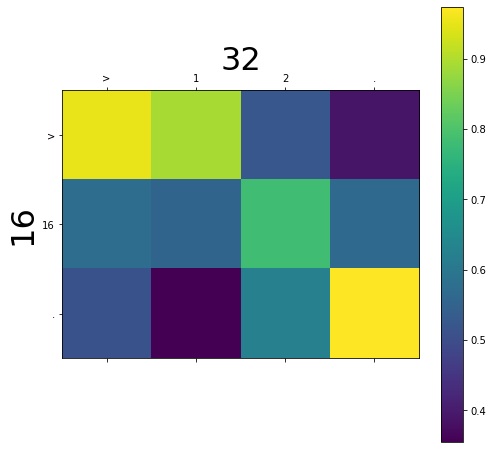

In [88]:
fig = plt.gcf()
fig.set_size_inches(8,8)
ax = plt.gca()
plt.colorbar(ax.matshow(cs_sims), ax=ax)
ax.set_xticks(np.arange(cs_sims.shape[1]))
ax.set_yticks(np.arange(cs_sims.shape[0]))
ax.set_xticklabels(t.decode(second_tokens, decode_special=True).split(' '))
ax.set_yticklabels(t.decode(first_tokens, decode_special=True).split(' '))

plt.xlabel(second_int, fontsize=32)
ax.xaxis.set_label_position('top') 
plt.ylabel(first_int, fontsize=32)

plt.show()

# When the model gets it wrong, what is the probability of the right sequence?

In [89]:
import Levenshtein

In [90]:
target_num = 277337

In [92]:
num_df = problem.form_prediction_df(model, device,  np.array([target_num]), args['model_args']['max_decode_size'], n_beams=10)
num_df['lev_dist'] = num_df.apply(lambda x: Levenshtein.distance(x['pred_str'].replace(' _', ''), x['target_factor_str']), axis=1)
num_df

  0%|          | 0/1 [00:00<?, ?it/s]

,input_num,model_input,beam_idx,log_prob,pred_str,pred_factor_list,product,num_pred_factors,num_prime_factors_pred,percent_prime_factors_pred,correct_product,correct_factorization,pred_same_as_input,input_is_prime,target_factor_str,target_factor_list,num_target_factors,min_target_prime_factor_if_composite,lev_dist
0,277337,"[>, 10, 8, 4, 17, .]",0,-0.079663,> 10 4 17 . _ _,[9137],9137,1,1,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,9
1,277337,"[>, 10, 8, 4, 17, .]",1,-2.846211,> 17 x 1 4 1 .,"[17, 1021]",17357,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,8
2,277337,"[>, 10, 8, 4, 17, .]",2,-5.179715,> 13 x 1 16 29 .,"[13, 1409]",18317,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,5
3,277337,"[>, 10, 8, 4, 17, .]",3,-5.422822,> 1 11 x 13 7 .,"[41, 397]",16277,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,5
4,277337,"[>, 10, 8, 4, 17, .]",4,-6.021946,> 1 13 x 13 29 .,"[43, 419]",18017,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,2
5,277337,"[>, 10, 8, 4, 17, .]",5,-6.156577,> 23 x 24 19 . _,"[23, 739]",16997,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,7
6,277337,"[>, 10, 8, 4, 17, .]",6,-7.035812,> 2 11 x 8 7 .,"[71, 247]",17537,2,1,0.5,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,7
7,277337,"[>, 10, 8, 4, 17, .]",7,-7.724508,> 19 x 1 0 23 .,"[19, 923]",17537,2,1,0.5,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,7
8,277337,"[>, 10, 8, 4, 17, .]",8,-7.741051,> 1 11 x 15 7 .,"[41, 457]",18737,2,2,1.0,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,5
9,277337,"[>, 10, 8, 4, 17, .]",9,-8.014544,> 13 x 1 14 29 .,"[13, 1349]",17537,2,1,0.5,False,False,False,False,> 15 13 x 19 29 .,"[463, 599]",2,463,5


In [94]:
problem.form_label(target_num, args['data']['base'])

['>', 15, 13, 'x', 19, 29, '.']

In [96]:
def get_prob_of_factorization(number, factorization):
    tokens = t.encode(problem.form_input(number, args['data']['base']))
    tensor_input = torch.tensor(tokens).unsqueeze(0).to(device)
    
    factorization_input = torch.tensor(t.encode(factorization)).unsqueeze(0).to(device)
    
    model_output = torch.softmax(model(tensor_input, factorization_input).squeeze(0), dim=-1)
    
    probs = model_output[torch.arange(model_output.size(0)-1),factorization_input[0,1:]]
    
    return probs.log().sum()

In [97]:
get_prob_of_factorization(target_num, num_df.iloc[0]['target_factor_str'].strip().split(' '))

tensor(-70.3656, device='cuda:0', grad_fn=<SumBackward0>)

In [98]:
torch.tensor(t.encode(num_df.iloc[0]['target_factor_str'].strip().split(' '))).unsqueeze(0).to(device)

tensor([[33, 15, 13, 30, 19, 29, 32]], device='cuda:0')